In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Question 1

In [3]:
def apply_frequency_filter(image, filter_type='ideal', pass_type='low', D0=50, n=2):
    # Convert  to float and normalize
    img = image.astype(np.float32) / 255.0
    M, N = img.shape

    # 2D FT and shift the zero-frequency component to the center for better visualisation
    F = np.fft.fftshift(np.fft.fft2(img))

    # Frequency grid
    u, v = np.meshgrid(np.arange(-M//2, M//2), np.arange(-N//2, N//2), indexing='ij')
    D = np.sqrt(u**2 + v**2)

    # LPF
    if filter_type == 'ideal':
        H = np.double(D <= D0)
    elif filter_type == 'gaussian':
        H = np.exp(-(D**2) / (2 * (D0**2)))
    elif filter_type == 'butterworth':
        H = 1 / (1 + (D / D0)**(2 * n))
    else:
        raise ValueError("filter_type must be 'ideal', 'gaussian', or 'butterworth'")

    # High-pass filter: complement of low-pass
    if pass_type == 'high':
        H = 1 - H

    # Apply filter in frequency domain (correlated in time domain, multiplied in frequency domain)
    G = F * H

    # Inverse and shift back
    g = np.real(np.fft.ifft2(np.fft.ifftshift(G)))

    # rescale
    g = np.clip(g, 0, 1)
    return g


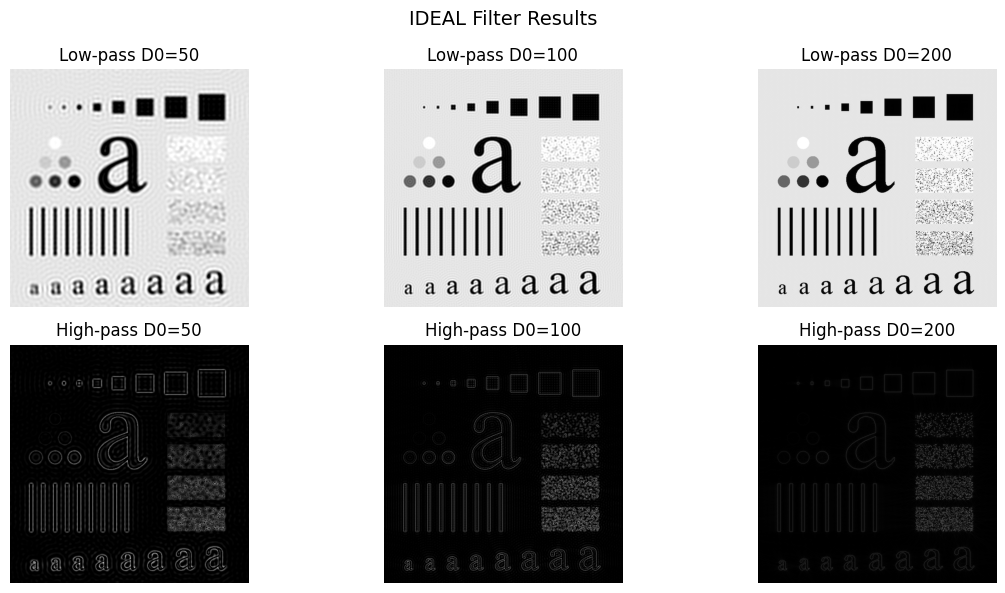

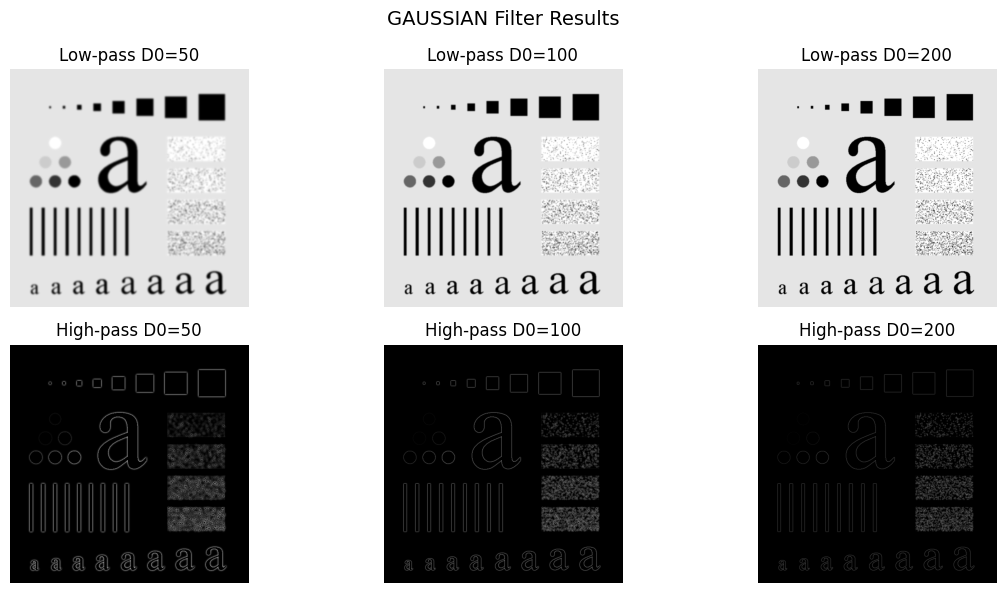

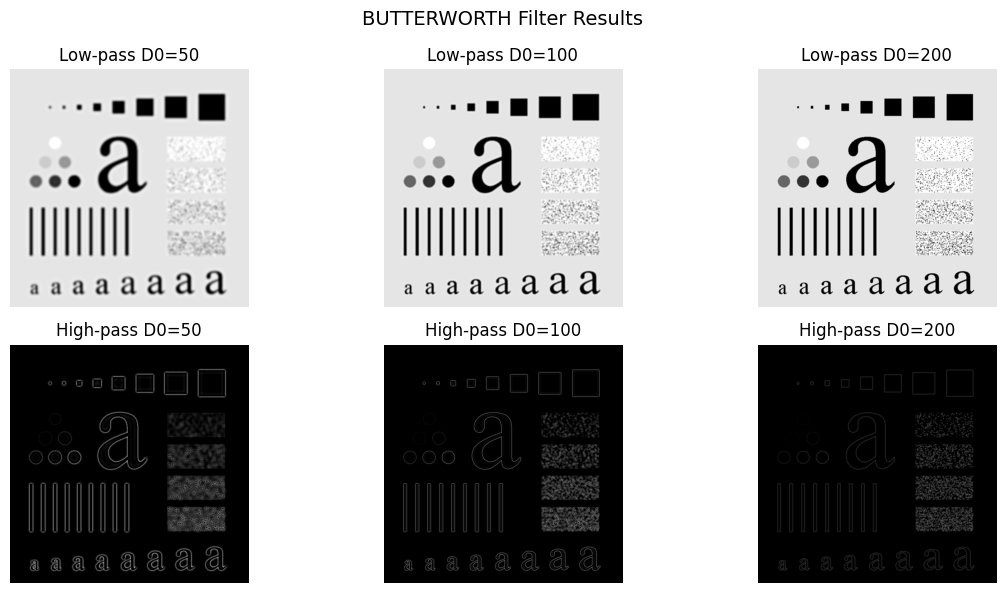

In [4]:
img = cv2.imread('a.tif', cv2.IMREAD_GRAYSCALE)

# parameters
kernel = [50, 100, 200]
filters = ['ideal', 'gaussian', 'butterworth']

for f in filters:
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'{f.upper()} Filter Results', fontsize=14)

    for i, D0 in enumerate(kernel):
        low = apply_frequency_filter(img, f, 'low', D0)
        high = apply_frequency_filter(img, f, 'high', D0)

        # LPF
        plt.subplot(2, len(kernel), i + 1)
        plt.imshow(low, cmap='gray')
        plt.title(f'Low-pass D0={D0}')
        plt.axis('off')

        # HPF
        plt.subplot(2, len(kernel), i + 1 + len(kernel))
        plt.imshow(high, cmap='gray')
        plt.title(f'High-pass D0={D0}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

1. Fourier Transform of an Image

$\[F(u, v) = \sum_{x=0}^{M-1}\sum_{y=0}^{N-1} f(x, y) \, e^{-j2\pi\left(\frac{ux}{M} + \frac{vy}{N}\right)}\]$

$\[f(x, y) = \frac{1}{MN} \sum_{u=0}^{M-1}\sum_{v=0}^{N-1} F(u, v) \, e^{j2\pi\left(\frac{ux}{M} + \frac{vy}{N}\right)}\]$


2. Frequency Domain Filtering

$\[G(u, v) = H(u, v) \cdot F(u, v)\]$

Then the filtered image is obtained using the inverse Fourier transform:

$\[g(x, y) = \mathcal{F}^{-1}\{ G(u, v) \}\]$

$\[D(u, v) = \sqrt{(u - M/2)^2 + (v - N/2)^2}\]$

3. Filters
(a) Ideal Low-Pass Filter

$\[H(u, v) =\begin{cases}1, & D(u, v) \leq D_0 \\0, & D(u, v) > D_0\end{cases}\]$

   - Sharp cutoff at $\( D_0 \)$

(b) Gaussian Low-Pass Filter

$\[H(u, v) = e^{-\frac{D(u,v)^2}{2D_0^2}}\]$

- Smoothly decreases with distance

(c) Butterworth Low-Pass Filter

$\[H(u, v) = \frac{1}{1 + \left(\frac{D(u,v)}{D_0}\right)^{2n}}\]$

- $\( n \)$: filter order (controls the slope of the transition)
- Smoother than ideal but sharper than Gaussian
- Larger $\( n \)$ → steeper transition

An HPF preserves only the edges and sudden changes.

# Question 2

**Noise functions:**

In [5]:
def salt_pepper_noise(image, salt_prob=0.05, pepper_prob=0.05):
    noisy = image.copy()
    total_pixels = image.size
    # Salt
    num_salt = int(total_pixels * salt_prob)
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy[coords[0], coords[1]] = 255
    # Pepper
    num_pepper = int(total_pixels * pepper_prob)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy[coords[0], coords[1]] = 0
    return noisy


def sinusoidal_noise(image, direction='horizontal', amplitude=20, frequency=10):
    # Convert to float for safe addition
    img = image.astype(np.float64)

    rows, cols = img.shape

    if direction == 'horizontal':
        x = np.arange(cols)
        sine_wave = amplitude * np.sin(2 * np.pi * frequency * x / cols)
        noise = np.tile(sine_wave, (rows, 1))
    elif direction == 'vertical':
        y = np.arange(rows)
        sine_wave = amplitude * np.sin(2 * np.pi * frequency * y / rows)
        noise = np.tile(sine_wave[:, np.newaxis], (1, cols)) # converts the same 1D sine wave into a column vector.
    else:
        raise ValueError("direction must be 'horizontal' or 'vertical'")

    # Add noise and clip values to make sure they don't surpass the threshold
    noisy_image = np.clip(img + noise, 0, 255).astype(np.uint8)

    return noisy_image

After obtaining the number of salt/ peppers that are going to be applied, we randomly select specific pixels using np.random.randint as it represents the coordinates of num_salt(or num_pepper) pixels that are going to comprise noise. 

- coords[0] is the selected rows and coords[1] is the selected columns, and we allocate either 255 or 0 to create the noise.

**sinusoidal noise:**
if it's applied horizontally, we need cols number of sinusoidal quantities. That's why we have $x / cols$.

    np.tile(..., (rows, 1)):

- Repeat the sine wave rows times vertically.
- Keep its horizontal structure (so it’s identical in every row).

## A

In [6]:
def contraharmonic_mean_filter(img, size=3, Q=1.5):
    eps = 1e-8  # to prevent division by zero
    padded = cv2.copyMakeBorder(img, size//2, size//2, size//2, size//2, cv2.BORDER_REFLECT)
    filtered = np.zeros_like(img, dtype=np.float64)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+size, j:j+size].astype(np.float64)
            
            # Add epsilon before power to avoid division by zero(pepper)
            region_safe = region + eps
            
            num = np.sum(np.power(region_safe, Q + 1))
            den = np.sum(np.power(region_safe, Q))
            
            filtered[i, j] = num / den if den != 0 else 0

    return np.clip(filtered, 0, 255).astype(np.uint8)

# Contraharmonic Mean Filter

$\hat{f}(x, y) = \frac{\sum_{(s, t) \in S_{xy}} [g(s, t)]^{Q + 1}}{\sum_{(s, t) \in S_{xy}} [g(s, t)]^{Q}}$

where:

- $g(s,t)$ is the intensity of a pixel within the neighborhood centered at $(x, y)$  
- $Q$ is the order of the filter (a tunable parameter)  
- $\hat{f}(x, y)$ is the output (filtered) pixel value

If $Q>0$, high intensities (white spots) loom remarkably, while darker pixels contribute less to the pixel. So it is adequate for eliminating pepper noise.

When $Q < 0$, the filter suppresses **salt noise** (bright noise), because negative powers amplify the effect of small gray-level values and reduce the effect of large ones. Therefore, bright pixels (such as salt noise) contribute very little to the sums, so their influence is minimized. Because salt pixels are very large, when there is a negative power, they shrink dramatically toward zero.
So the filter pays attention only to the normal and darker neighbors.

| $Q$ value | Effect                                                
|------------|-------------------------------------------------------
| $Q > 0$ | deteriorates effects of **pepper noise** (black dots) 
| $Q < 0$ | Suppresses **salt noise** (white dots)
| $Q = 0$ | **Arithmetic Mean Filter** (uniform smoothing)


## B

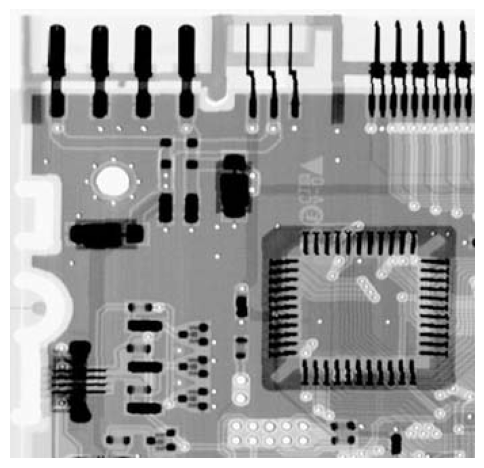

In [58]:
img = cv2.imread('IC.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## C

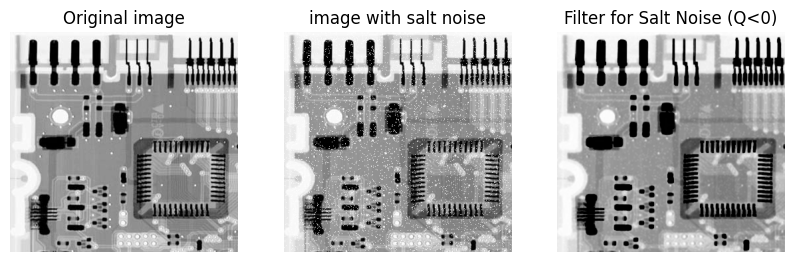

In [8]:
noisy_s = salt_pepper_noise(img, salt_prob=0.05, pepper_prob=0)
filtered_salt = contraharmonic_mean_filter(noisy_s, size=3, Q=-1.5) # AS the image is corrupted with salt noise. q = -1.5  causes the filter to give more weight to darker pixels in the neighborhood, effectively removing bright outliers. 

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(noisy_s, cmap='gray')
plt.title('image with salt noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(filtered_salt, cmap='gray')
plt.title('Filter for Salt Noise (Q<0)')
plt.axis('off')
plt.show()

Regions around black edges receive higher emphasis after filtering. The negative order $Q$ increases the contribution of low-intensity pixels, making edges appear darker and slightly enhancing black details while suppressing bright noise pixels.

## D

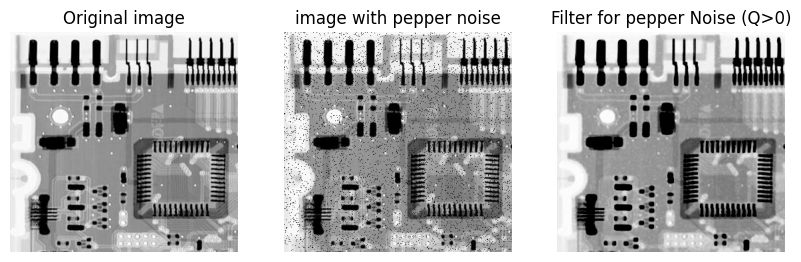

In [9]:
noisy_p = salt_pepper_noise(img, salt_prob=0, pepper_prob=0.05)
filtered_pepper = contraharmonic_mean_filter(noisy_p, size=3, Q=1.5)  # pepper noise

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(noisy_p, cmap='gray')
plt.title('image with pepper noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(filtered_salt, cmap='gray')
plt.title('Filter for pepper Noise (Q>0)')
plt.axis('off')
plt.show()

## E

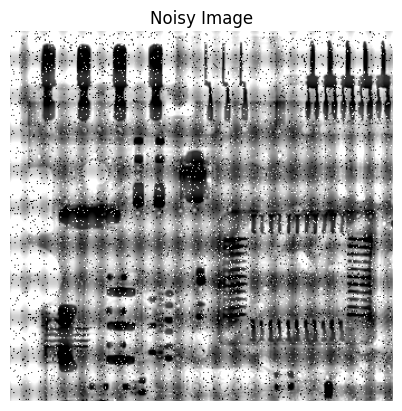

In [10]:
noisy_sp = salt_pepper_noise(img, salt_prob=0.05, pepper_prob=0.05)
noisy_sin_horizontally = sinusoidal_noise(noisy_sp, direction='horizontal', amplitude=40, frequency=20)
final_noisy = sinusoidal_noise(noisy_sin_horizontally, direction='vertical', amplitude=50, frequency=10)
plt.imshow(final_noisy, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')
plt.show()

### To remove the noise:

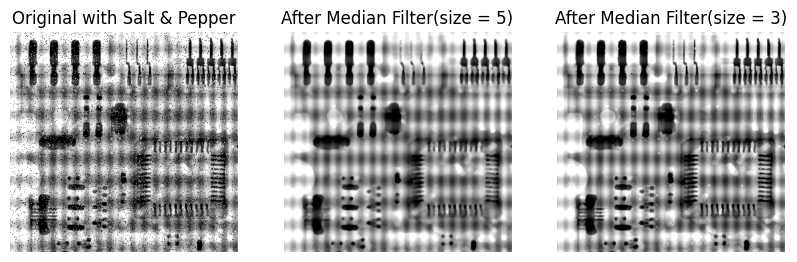

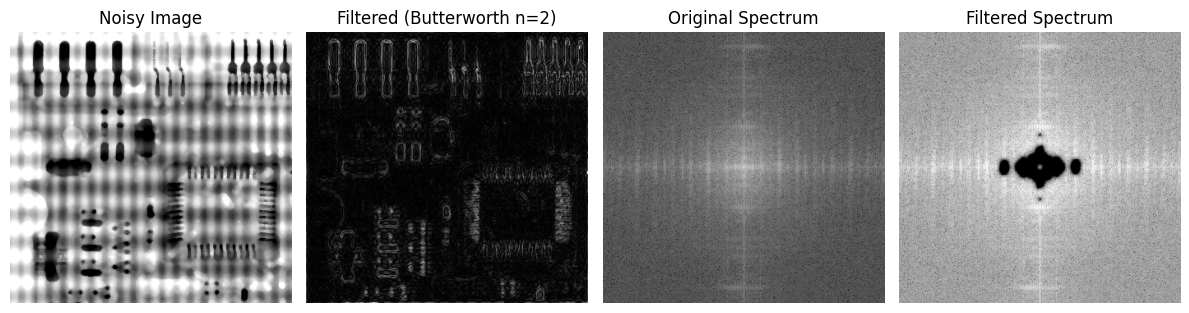

In [138]:
def remove_salt_and_pepper(img): 
    # Using kernel size of 5 and 3
    denoised5_img = cv2.medianBlur(img, 5)
    denoised3_img = cv2.medianBlur(img, 3)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original with Salt & Pepper")
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("After Median Filter(size = 5)")
    plt.imshow(denoised5_img, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("After Median Filter(size = 3)")
    plt.imshow(denoised3_img, cmap='gray')
    plt.axis('off')

    plt.show()

    return denoised5_img, denoised3_img


img_median5, img_median3 = remove_salt_and_pepper(final_noisy)


def remove_periodic_noise_butterworth(noisy_img, order=2, D0=10):
    rows, cols = noisy_img.shape
    crow, ccol = rows // 2, cols // 2
    
    # 1. FFT transformation
    f = np.fft.fft2(noisy_img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    
    # 2. Detect Noise Peaks (Auto-detection)
    thresh = np.percentile(magnitude_spectrum, 99.5)
    noise_indices = np.argwhere(magnitude_spectrum > thresh)
    
    # 3. Create Butterworth Mask
    # Initialize mask as 1 (all pass)
    mask = np.ones((rows, cols), np.float32)
    
    # Define grid of distances from the center (u, v)
    u = np.arange(rows)
    v = np.arange(cols)
    idx_u, idx_v = np.meshgrid(u, v, indexing='ij')
    safe_radius = 9
    # Iterate through detected noise points (peaks)
    for nr, nc in noise_indices:
        dist_from_center = np.sqrt((nr - crow)**2 + (nc - ccol)**2)
        if dist_from_center <= safe_radius:
            continue
            
        # Distance from the current noise peak (shifted to center logic)
        # D_k(u, v) = distance from point (u,v) to noise center (nr, nc)
        D_uv = np.sqrt((idx_u - nr)**2 + (idx_v - nc)**2)
        
        # Avoid division by zero
        D_uv[D_uv == 0] = 1e-5
        
        # Butterworth Notch Reject formula: 1 / (1 + (D0 / D_uv)^(2n))
        # Note: This creates a "hole" at (nr, nc)
        notch_filter = 1 / (1 + (D0 / D_uv)**(2 * order))
        
        # Apply this notch to the main mask
        mask *= notch_filter

    fshift_filtered = fshift * mask

    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_filtered = np.abs(img_back)

    magnitude_spectrum_filtered = 20 * np.log(np.abs(fshift_filtered) + 1)
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(1, 4, 1)
    plt.imshow(noisy_img, cmap='gray')
    plt.title('Noisy Image')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(img_filtered, cmap='gray')
    plt.title(f'Filtered (Butterworth n={order})')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Original Spectrum')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(magnitude_spectrum_filtered, cmap='gray')
    plt.title('Filtered Spectrum')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    return img_filtered, magnitude_spectrum_filtered

img_filtered, magnitude_spectrum_filtered = remove_periodic_noise_butterworth(img_median5, order=2, D0=5)

There is a periodic noise with salt and pepper noise visible in the image. So notch filter would be beneficial to use. However, we should first use FFT to make sure about the periodic noise and its characteristics. Moreover, salt and pepper noise are vividly noticeable, which can be demolished with a median filter.

I see multiple spikes in both axes, this means there was a sin/cos noise added to the signal.
Since I figured using a kernel size of 5 is more beneficial, I'll use it for further de-noising process.
Additionally, I retained DC point as it holds signal's average amount while processing.

I assume that we should find the mean of frequency spectrum and replace it with the amount of coordinates that are distinguished as noise. Plus, all harmonics should be studied. I really tried, but I couldn't implement what I had in mind.

# Question 3

## A

In [ ]:
def motion_blur(image, LEN, THETA):
    # Create the kernel matrix
    size = int(LEN)
    if size % 2 == 0: 
        size += 1 
    kernel = np.zeros((size, size))
    
    center = (size // 2, size // 2)
    angle_rad = np.deg2rad(THETA) 
    x_offset = int((LEN/2) * np.cos(angle_rad))
    y_offset = int((LEN/2) * np.sin(angle_rad))
    
    # motion line
    cv2.line(kernel, (center[0] - x_offset, center[1] - y_offset), (center[0] + x_offset, center[1] + y_offset), 1, thickness=1)
    
    # kernel's sum must be 1
    kernel = kernel / np.sum(kernel)
    blurred = cv2.filter2D(image, -1, kernel) 
    
    blurred = np.clip(blurred, 0, 255)
    blurred = blurred.astype('uint8')
    
    return blurred, kernel

### Algorithm:

This function simulates the effect of linear motion blur, which occurs when the camera or subject moves during the exposure time. The process involves creating a Point Spread Function (PSF) and convolving it with the image.

1. As mentioned in the class, the mask's matrix symmetry is crucial to advocate for reasonable result. It is mainly due to the fact that we need to find the centre of the mask to apply the filter, which is unattainable if we have even numbers of pixels. So I $add_1$ to the length to retain the matrix symmetry to build a len x len size.
2. $sin$ and $cos$ is then used to form the direction that the kernel must move in.
3. As used in coursework, pixels are then divided by kernel size.
4. image is then correlated with the kernel and $-1$ is written to preserve the input size for the output.

### Theory

#### Modeling Motion Geometry

$\theta_{rad} = \theta_{deg} \times \frac{\pi}{180}$

$\Delta x = \frac{L}{2} \cos(\theta_{rad})$

$\Delta y = \frac{L}{2} \sin(\theta_{rad})$

The line is drawn from $(c_x - \Delta x, c_y - \Delta y)$$to$$(c_x + \Delta x, c_y + \Delta y)$.

#### Energy Preservation (Normalization)
After drawing the line, the kernel $H$ contains 1s along the path and 0s elsewhere. To prevent the image from becoming brighter or darker during blurring, the sum of all elements in the kernel must equal 1. This is called energy preservation:

$H_{normalized}(u,v) = \frac{H(u,v)}{\sum_{i}\sum_{j} H(i,j)}$

#### Convolution and Rescaling

$$g(x,y) = f(x,y) * h(x,y) = \sum_{s=-a}^{a} \sum_{t=-b}^{b} h(s,t) f(x-s, y-t)$$
$$g_{out} = 255 \times \frac{g_{in} - \min(g_{in})}{\max(g_{in}) - \min(g_{in})}$$

## B

In [ ]:
img = cv2.imread('DIP.png', cv2.IMREAD_GRAYSCALE)
blurred_img, psf_kernel = motion_blur(img, 20, 30)

def gaussian_noise(img, mean, variance):
    # noise is float
    img_float = img / 255.0
    sigma = variance ** 0.5 #square root of variance
    
    noise = np.random.normal(mean, sigma, img_float.shape)
    noisy_img_float = img_float + noise
    noisy_img_float = np.clip(noisy_img_float, 0, 1)
    
    return (noisy_img_float * 255).astype('uint8')

noisy_blurred = gaussian_noise(blurred_img, mean=0, variance=0.001)

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("Blurred Image")
plt.imshow(blurred_img, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Blurred + Noise")
plt.imshow(noisy_blurred, cmap='gray')
plt.axis('off')

### 1. Additive White Gaussian Noise
$$g(x,y) = f(x,y) + \eta(x,y)$$
Where:
* $f(x,y)$ is the original (or blurred) image pixel value at coordinates (x, y).
* $\eta(x,y)$ is the noise component added to that pixel.
* $g(x,y)$ is the resulting noisy image.

### 2. Converting to Float
Before adding noise, I convert the image from integer format (0-255) to floating-point format (0.0-1.0) as noise itself is float.

$$\text{pixel}_{float} = \frac{\text{pixel}_{int}}{255.0}$$

### 3. Gaussian Noise Characteristics
$$p(z) = \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{(z-\mu)^2}{2\sigma^2}}$$

* $\mu = 0$. It does not brighten or darken the overall image, but adds variations around the true pixel value.
* Variance ($\sigma^2$) = 0.001

### 4. Clipping and Restoration
After adding the noise, some pixel values may exceed the valid range. Therefore, rescaling is required. It should subsequently be multiplied by 255 to apply to the normal gray scale.
$$g_{final}(x,y) = \begin{cases} 1 & \text{if } g(x,y) > 1 \\ 0 & \text{if } g(x,y) < 0 \\ g(x,y) & \text{otherwise} \end{cases}$$

$$\text{Output} = \lfloor g_{final}(x,y) \times 255 \rfloor$$

## C

In [ ]:
def inverse_filter(input_img, kernel):
    rows, cols = input_img.shape
    k_h, k_w = kernel.shape

    # Pad the kernel to match the image size
    padded_kernel = np.zeros((rows, cols))
    
    center_h = (rows - k_h) // 2
    center_w = (cols - k_w) // 2
    padded_kernel[center_h:center_h+k_h, center_w:center_w+k_w] = kernel
    
    shifted_kernel = np.fft.ifftshift(padded_kernel)
    
    G = np.fft.fft2(input_img.astype(np.float32) / 255.0)                   
    H = np.fft.fft2(shifted_kernel) 
    
    epsilon = 1e-3 
    H_mag_sq = np.abs(H) ** 2

    H_inv = np.conj(H) / (H_mag_sq + epsilon)
    F_hat = G * H_inv
    
    restored_complex = np.fft.ifft2(F_hat)
    restored = np.real(restored_complex)
    
    restored = np.clip(restored, 0, 1)
    
    return (restored * 255).astype('uint8')

In [ ]:
restored_img = inverse_filter(noisy_blurred, psf_kernel)
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.title("Blurred + Noise")
plt.imshow(noisy_blurred, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Restored (Inverse Filter)")
plt.imshow(restored_img, cmap='gray')
plt.axis('off')

plt.show()

# Inverse Filtering

Inverse filtering is a restoration technique that attempts to recover the original image from a blurred image by reversing the degradation process in the frequency domain.

### The Convolution Theorem
In the spatial domain, the degraded image $g(x,y)$is produced by the convolution of the original image $f(x,y)$ and the blur kernel $h(x,y)$:

$$g(x,y) = f(x,y) * h(x,y)$$
$$G(u,v) = F(u,v) H(u,v)$$

### The Inverse Formula
To recover the original image $F(u,v)$, we simply divide the blurred spectrum by the kernel spectrum:

$$\hat{F}(u,v) = \frac{G(u,v)}{H(u,v)} $$

To prevent computational crashes or "Exploding" values, we add a tiny regularization term ($\epsilon$) to the denominator:

$$\hat{F}(u,v) = \frac{G(u,v)}{H(u,v) + \epsilon} = \frac{F(u,v)H(u,v) + N(u,v)}{H(u,v) + \epsilon}$$
Centering:
$$\mathfrak{F}\{h(x-x_0, y-y_0)\} = H(u,v)e^{-j2\pi(\frac{ux_0}{M} + \frac{vy_0}{N})}$$

Instability:
- Motion blur acts as a low-pass filter. In the frequency domain, values of $H(u,v)$ drop off rapidly as it moves away from the center. At certain high frequencies, $H(u,v)$ becomes zero or extremely close to zero.
- Noise Amplification: Noise $N(u,v)$ usually exists across all frequencies (white noise). When we divide a noise value (even a small one) by a value close to zero $(H≈0)$, the result approaches infinity.

#### Regularized Inversion

I tried the ordinary inversion methods and I didn't get adequate results. Thus, I used a regularized method.

$$
\hat{F} = F + \frac{N}{H} \quad (\text{if } H \to 0, \text{ then } \frac{N}{H} \to \infty)
$$

$$
H_{inv}(u,v) = \frac{H^*(u,v)}{|H(u,v)|^2 + \epsilon}
$$

* **High SNR (Strong Signal):** When $|H|^2 \gg \epsilon$, the term $\epsilon$ is negligible:
    $$
    \frac{H^*}{|H|^2} = \frac{H^*}{H \cdot H^*} = \frac{1}{H}
    $$
* **Low SNR (Weak Signal):** When $|H|^2 \approx 0$ (typically high frequencies dominated by noise), the denominator is dominated by $\epsilon$. This limits the magnitude of the quotient, preventing noise amplification.

## D

In [ ]:
def wiener_filter(input_img, kernel, K=0.01):
    rows, cols = input_img.shape
    
    # Pad kernel
    padded_kernel = np.zeros((rows, cols))
    k_h, k_w = kernel.shape
    padded_kernel[:k_h, :k_w] = kernel
    
    # FFT
    G = np.fft.fft2(input_img)
    H = np.fft.fft2(padded_kernel, s=(rows, cols))
    
    # Wiener Formula
    H_abs_sq = np.abs(H) ** 2
    W = np.conj(H) / (H_abs_sq + K)
    F_hat = W * G
    
    # Inverse FFT
    restored = np.fft.ifft2(F_hat)
    restored = np.abs(restored)
    
    # Normalize result here for display
    restored = cv2.normalize(restored, None, 0, 255, cv2.NORM_MINMAX)
    return restored.astype('uint8')

The Wiener Filter (Minimum Mean Square Error Filter) is designed explicitly to handle the weakness of the Inverse Filter. Instead of just dividing by H, it incorporates a statistical model of the noise to minimize the error between the original and restored image.
$$F^(u,v)=[H(u,v)1​∣H(u,v)∣2+K∣H(u,v)∣2​]G(u,v)$$

Where K is a constant related to the Signal-to-Noise Ratio (SNR).

- High SNR (Strong Signal, H is large): If $∣H∣2≫K$ (low noise or strong signal), the term $∣H∣2+K∣H∣2​≈1$. The formula simplifies to H1​, which acts exactly like the Inverse Filter.
- Low SNR (Weak Signal, H is small): If $∣H∣2≪K$ (high noise or zero-crossing frequencies), the term approaches 0. This effectively shuts off the filter at frequencies where noise dominates, preventing the "explosion" of values seen in the Inverse Filter.

*The Wiener Filter is significantly better.* It prevents noise amplification by adjusting the filter strength based on the signal-to-noise ratio, whereas the Inverse Filter blindly amplifies noise. The difference is maximized when the noise variance is high. If Noise ≈0, the Wiener filter converges to the Inverse Filter. As noise increases, the Inverse Filter fails, while the Wiener filter remains stable.

## E

In [ ]:
params = [
    (20, 30),  # 1. Baseline
    (60, 30),  # 2. High LEN (Harder to restore)
    (20, 0),   # 3. Horizontal Blur (Look at vertical lines)
    (20, 90)   # 4. Vertical Blur (Look at horizontal lines)
]

plt.figure(figsize=(15, 5))
plt.suptitle("Part E: Effect of LEN and THETA on Reconstruction Quality")

for i, (L, T) in enumerate(params):
    b_img, k = motion_blur(img, L, T)
    
    restored_img = wiener_filter(noisy_blurred, k, K=0.01)
    
    plt.subplot(1, 4, i+1)
    plt.title(f"Restored\nL={L}, T={T}")
    plt.imshow(restored_img, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

LEN: Increasing Length makes the blur stronger (more zero-crossings in frequency since the sinc becomes more compressed), making it harder to restore details.

THETA: Changing Angle changes the direction of the blur.